<a href="https://colab.research.google.com/github/iacopoooo/Tesi/blob/main/Colab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seed di casualità impostato a: 43 per garantire la riproducibilità.
Trovate 7940 sequenze. Vocabolario di 20 eventi.
Distribuzione classi: Normali=7627, Anomale=313


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Architettura del modello (stato 'Built' con tutti i parametri):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 64)         │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,657 (432.25 KB)

 Trainable params: 110,657 (432.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.9117 - loss: 0.4953 - precision: 0.0724 - recall: 0.0592 - val_accuracy: 0.9780 - val_loss: 0.1241 - val_precision: 1.0000 - val_recall: 0.4444 - learning_rate: 5.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.9773 - loss: 0.2642 - precision: 0.9838 - recall: 0.4132 - val_accuracy: 0.9780 - val_loss: 0.1224 - val_precision: 1.0000 - val_recall: 0.4444 - learning_rate: 5.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9773 - loss: 0.2546 - precision: 0.9838 - recall: 0.4132 - val_accuracy: 0.9780 - val_loss: 0.1249 - val_precision: 1.0000 - val_recall: 0.4444 - learning_rate: 5.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.9773 - loss: 0.2560 - precision: 0.9838 - recall: 0.4132 - val_accuracy: 0.9780 - val_loss: 0.1253 - val_precision: 1.0000 - val_recall: 0.4444 - learning_rate: 5.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━

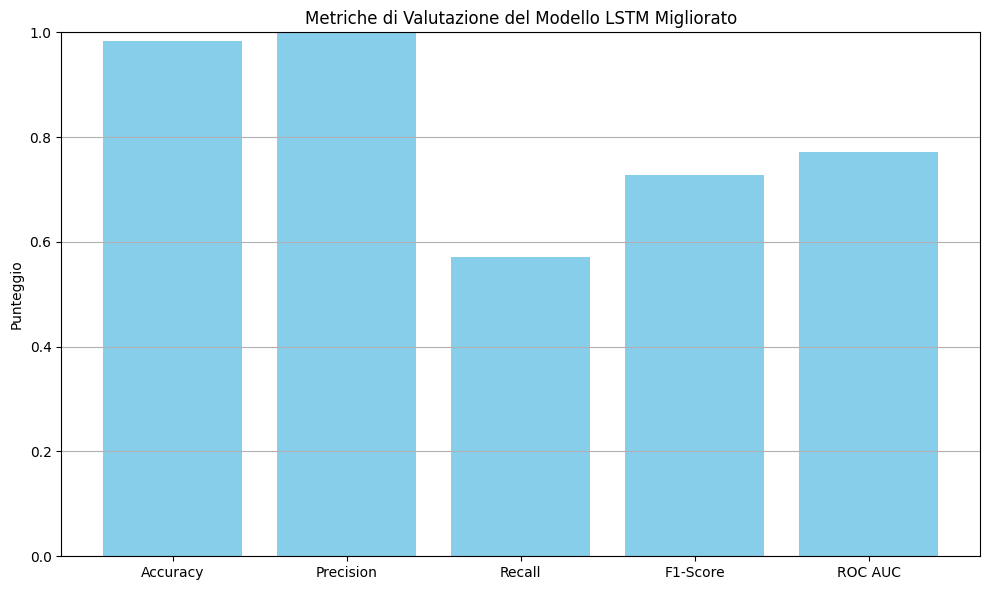


Generazione grafici di analisi avanzata per il modello LSTM...


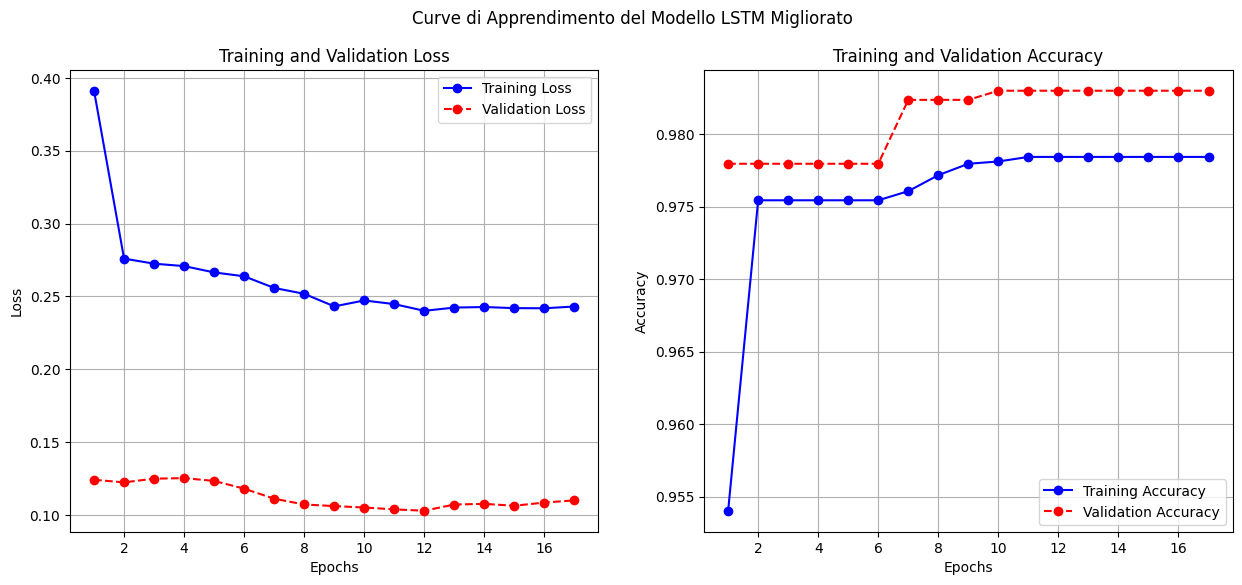

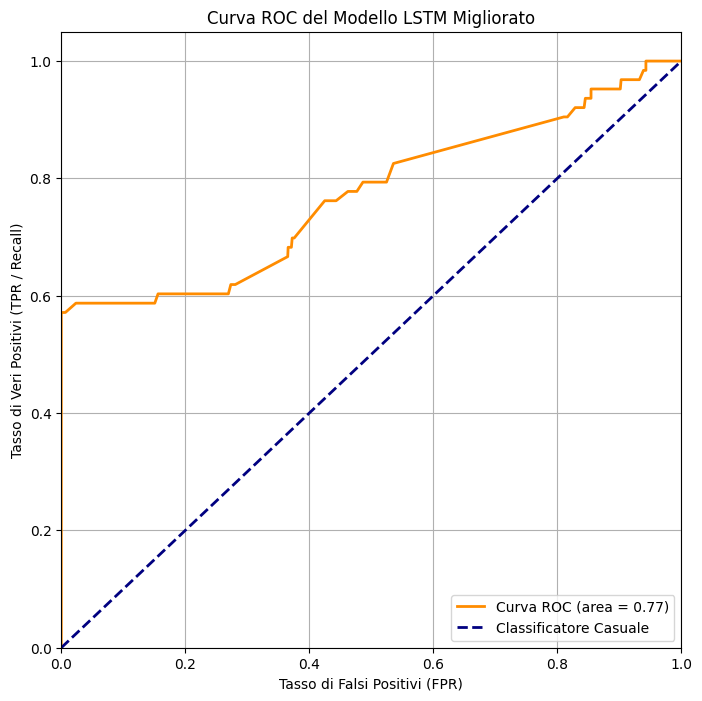


Generazione grafici di analisi della distribuzione delle probabilità...


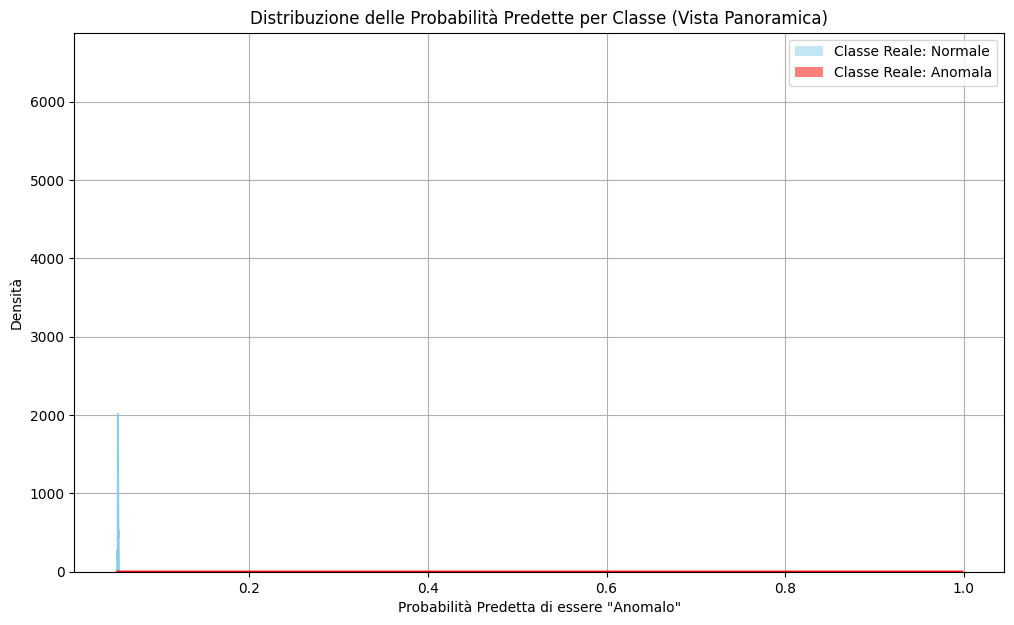

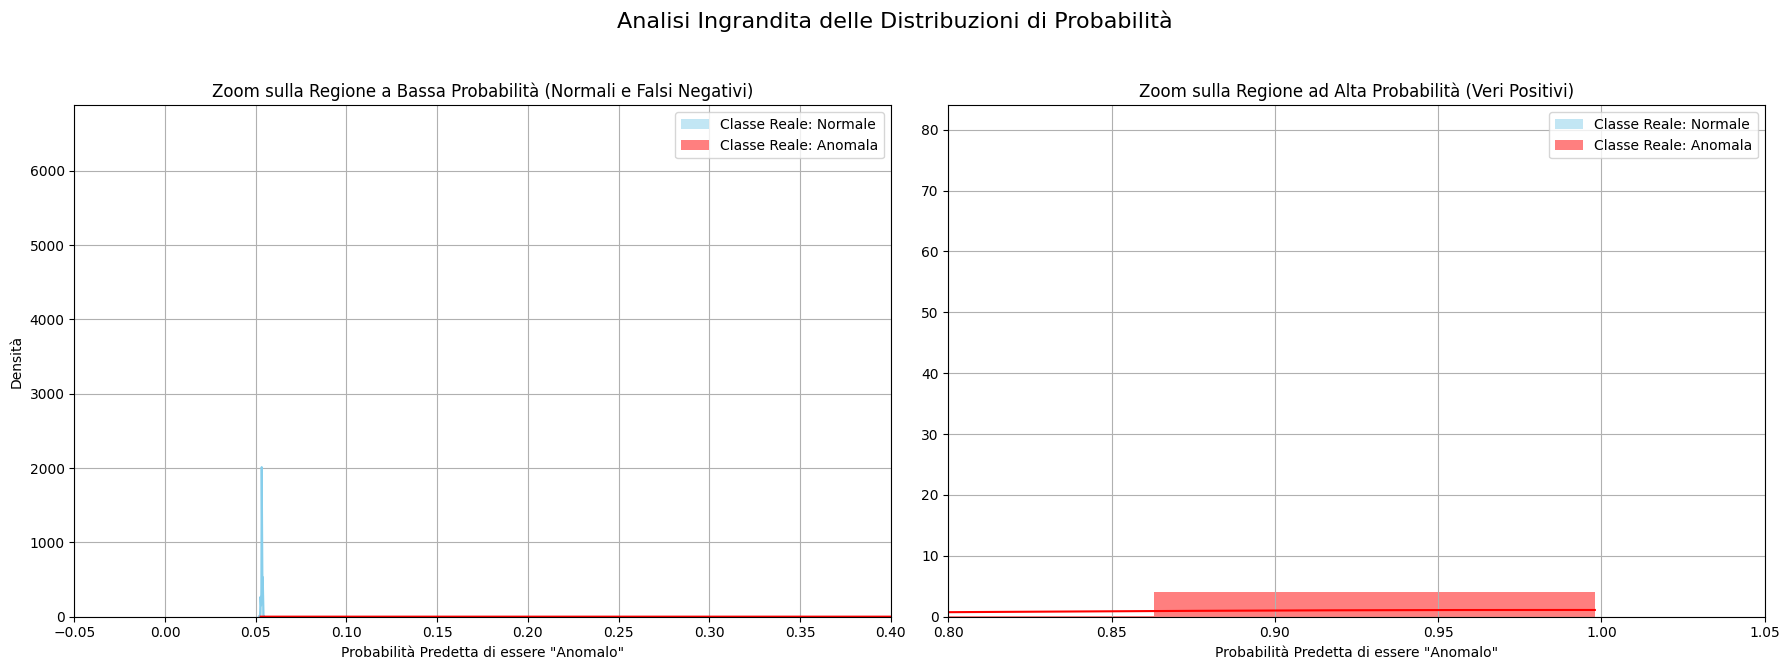

In [4]:
# ==============================================================================
#                      BLOCCO IMPORT COMPLETO E CORRETTO
# ==============================================================================
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Import da Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
)

# --- Import da TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# ==============================================================================

import tensorflow as tf
import numpy as np
import random
import os

# --- INIZIO BLOCCO PER LA RIPRODUCIBILITÀ ---

# Imposta un seed per Python, NumPy e TensorFlow
seed_value = 43 # Scegli un numero qualsiasi, l'importante è che sia sempre lo stesso

# 1. Imposta il seed per l'ambiente Python
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Imposta il seed per il generatore di numeri casuali di Python
random.seed(seed_value)

# 3. Imposta il seed per NumPy
np.random.seed(seed_value)

# 4. Imposta il seed per TensorFlow
tf.random.set_seed(seed_value)

# 5. (Opzionale, per GPU) Forza TensorFlow a usare algoritmi deterministici
# Questo può rallentare leggermente il training, ma garantisce la riproducibilità
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Seed di casualità impostato a: {seed_value} per garantire la riproducibilità.")
# --- FINE BLOCCO PER LA RIPRODUCIBILITÀ ---

# --- 1. Caricamento file ---
log_file = '/content/drive/MyDrive/HDFS_100k.log_structured.csv'
label_file = '/content/drive/MyDrive/anomaly_label.csv'
df_logs = pd.read_csv(log_file)
df_labels = pd.read_csv(label_file)

# --- 2. Parsing dei log ---
log_data = defaultdict(list)
for _, row in df_logs.iterrows():
    content = row["Content"]
    event_id = row["EventId"]
    match = re.search(r'blk_-?\d+', content)
    if match:
        blk_id = match.group(0)
        log_data[blk_id].append(event_id)

# --- 3. Etichette ---
label_dict = dict(zip(df_labels['BlockId'], df_labels['Label'].apply(lambda x: 1 if x == 'Anomaly' else 0)))

# --- 4. Costruzione vocabolario ---
all_events = set(e for seq in log_data.values() for e in seq)
event_vocab = {e: i + 1 for i, e in enumerate(sorted(all_events))}
vocab_size = len(event_vocab) + 1
max_seq_length = 50

# --- 5. Sequenze numeriche e label ---
sequences, sequence_labels = [], []
for blk_id, events in log_data.items():
    if blk_id in label_dict:
        numeric_seq = [event_vocab[e] for e in events]
        sequences.append(numeric_seq)
        sequence_labels.append(label_dict[blk_id])

X = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')
y = np.array(sequence_labels)

print(f"Trovate {len(X)} sequenze. Vocabolario di {vocab_size} eventi.")
print(f"Distribuzione classi: Normali={sum(y==0)}, Anomale={sum(y==1)}")

# --- 6. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=seed_value, # Usa lo stesso seed.
    stratify=y
)

# --- 7. MODELLO LSTM "STABILE E CONSERVATIVO" ---
# Torniamo al modello originale, che era più semplice e stabile
model_stable = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_seq_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3), # Un Dropout moderato
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# MODIFICA CHIAVE: Learning rate più basso per evitare esplosioni
optimizer = Adam(learning_rate=0.0005)

model_stable.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# --- INIZIO AGGIUNTA PER VISUALIZZARE IL SUMMARY COMPLETO ---

# Costruiamo esplicitamente il modello fornendo la forma dell'input atteso.
# 'None' rappresenta la dimensione del batch, che può variare.
# 'max_seq_length' è la lunghezza delle tue sequenze (50).
model_stable.build(input_shape=(None, max_seq_length))

print("\nArchitettura del modello (stato 'Built' con tutti i parametri):")
model_stable.summary()

# --- FINE AGGIUNTA ---

# --- 8. ADDESTRAMENTO "STABILE E CONSERVATIVO" ---
early_stopping = EarlyStopping(
    monitor='val_loss', # La metrica più affidabile
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6 # Riduciamo più dolcemente
)

# MODIFICA CHIAVE: Un class_weight meno aggressivo
class_weight_stable = {0: 1, 1: 3}

history = model_stable.fit(
    X_train, y_train,
    epochs=30, # Diamo abbastanza tempo
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_stable,
    callbacks=[early_stopping, reduce_lr]
)

# --- 9. Valutazione ---
y_pred_prob = model_stable.predict(X_test).ravel()

y_pred_class = (y_pred_prob > 0.5).astype(int)

print("\n--- Valutazione Finale del Modello Migliorato ---")
print(classification_report(y_test, y_pred_class))
print("Matrice di Confusione:")
print(confusion_matrix(y_test, y_pred_class))

# --- 10. Grafici di Valutazione e Analisi ---
# (Il resto del codice di plotting può rimanere invariato)
# ...

# --- 10. Grafici di Valutazione e Analisi ---

# Grafico 1: Metriche Principali (Barplot)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Metriche di Valutazione del Modello LSTM Migliorato')
plt.ylabel('Punteggio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Grafici Aggiuntivi
print("\nGenerazione grafici di analisi avanzata per il modello LSTM...")

# Grafico 2: Curve di Apprendimento
# --- CORREZIONE CHIAVE: USA 'history' DALL'ULTIMO ADDESTRAMENTO ---
history_dict = history.history
# -------------------------------------------------------------------
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(epochs, loss_values, 'bo-', label='Training Loss')
ax1.plot(epochs, val_loss_values, 'ro--', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
ax2.plot(epochs, val_accuracy_values, 'ro--', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.suptitle('Curve di Apprendimento del Modello LSTM Migliorato')
plt.show()

# Grafico 3: Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificatore Casuale')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasso di Falsi Positivi (FPR)')
plt.ylabel('Tasso di Veri Positivi (TPR / Recall)')
plt.title('Curva ROC del Modello LSTM Migliorato')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()





# Grafico 4: Distribuzione delle Probabilità Predette
print("\nGenerazione grafici di analisi della distribuzione delle probabilità...")

# Separiamo le probabilità predette in base alla classe reale
prob_normal = y_pred_prob[y_test == 0]
prob_anomaly = y_pred_prob[y_test == 1]

# --- Grafico 4.1: Vista Panoramica (0.0 a 1.0) ---
plt.figure(figsize=(12, 7))
sns.histplot(prob_normal, color="skyblue", label='Classe Reale: Normale', kde=True, stat="density", linewidth=0)
sns.histplot(prob_anomaly, color="red", label='Classe Reale: Anomala', kde=True, stat="density", linewidth=0)
plt.title('Distribuzione delle Probabilità Predette per Classe (Vista Panoramica)')
plt.xlabel('Probabilità Predetta di essere "Anomalo"')
plt.ylabel('Densità')
plt.legend()
plt.grid(True)
plt.show()


# --- Grafico 4.2: Viste Ingrandite ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Analisi Ingrandita delle Distribuzioni di Probabilità', fontsize=16)

# Sotto-grafico A: Zoom sulla regione a bassa probabilità (dove si concentrano i Normali)
sns.histplot(prob_normal, color="skyblue", label='Classe Reale: Normale', kde=True, stat="density", linewidth=0, ax=ax1)
sns.histplot(prob_anomaly, color="red", label='Classe Reale: Anomala', kde=True, stat="density", linewidth=0, ax=ax1)
ax1.set_title('Zoom sulla Regione a Bassa Probabilità (Normali e Falsi Negativi)')
ax1.set_xlabel('Probabilità Predetta di essere "Anomalo"')
ax1.set_ylabel('Densità')
ax1.set_xlim(-0.05, 0.4) # Mostra solo la regione tra 0.0 e 0.4
ax1.legend()
ax1.grid(True)

# Sotto-grafico B: Zoom sulla regione ad alta probabilità (dove dovrebbero essere le Anomalie)
sns.histplot(prob_normal, color="skyblue", label='Classe Reale: Normale', kde=True, stat="density", linewidth=0, ax=ax2)
sns.histplot(prob_anomaly, color="red", label='Classe Reale: Anomala', kde=True, stat="density", linewidth=0, ax=ax2)
ax2.set_title('Zoom sulla Regione ad Alta Probabilità (Veri Positivi)')
ax2.set_xlabel('Probabilità Predetta di essere "Anomalo"')
ax2.set_ylabel('') # Rimuoviamo l'etichetta Y per pulizia
ax2.set_xlim(0.8, 1.05) # Mostra solo la regione tra 0.8 e 1.0
# Regoliamo l'asse Y per rendere visibile la piccola distribuzione rossa
# Calcoliamo l'altezza massima delle barre rosse in questo intervallo
counts_anomaly, _ = np.histogram(prob_anomaly, bins=30, range=(0.8, 1.0))
if counts_anomaly.size > 0 and counts_anomaly.max() > 0:
    ax2.set_ylim(0, counts_anomaly.max() * 3) # Diamo un po' di spazio in alto
else:
    ax2.set_ylim(0, 1) # Fallback se non ci sono campioni in questo range
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
